<a href="https://colab.research.google.com/github/constructor-s/aps1080_winter_2021/blob/main/A3/A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A3: TD(n) and Mountain Car
==========================

> Submit Assignment
> 
> *   Due Tuesday by 11:59pm
> *   Points 100
> *   Submitting a file upload
> *   File Types pdf
> 
> In this assignment we are going to apply the TD(n) methods to solve the > Mountain Car problem.
> 
> By now, you should know how to load OpenAI gym environments:
> 
> env = gym.make('MountainCar-v0')



In [8]:
#%% Set up rendering

if True:
    !apt install xvfb
    !pip install pyvirtualdisplay
    from pyvirtualdisplay import Display
    display = Display(visible=False, size=(400, 300))
    display.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 784 kB in 0s (2,858 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 160975 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.8_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.8) ...
Setting up xvfb (2:1.19.6-1ubuntu4.8) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [3]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import *
from IPython.display import clear_output

env = gym.make('MountainCar-v0')

Exercise 1: Prelims
-------------------

> These are useful exercises to develop facility with the environment prior to the graded component of the assignment. Explore the above environment as we've done in past assignments and exercises.
> 
> Develop a MC controller and assess its performance.


In [4]:
#%% Set up the environment
"""
Reference:

Description:
    The agent (a car) is started at the bottom of a valley. For any given
    state the agent may choose to accelerate to the left, right or cease
    any acceleration.
Source:
    The environment appeared first in Andrew Moore's PhD Thesis (1990).
Observation:
    Type: Box(2)
    Num    Observation               Min            Max
    0      Car Position              -1.2           0.6
    1      Car Velocity              -0.07          0.07
Actions:
    Type: Discrete(3)
    Num    Action
    0      Accelerate to the Left
    1      Don't accelerate
    2      Accelerate to the Right
    Note: This does not affect the amount of velocity affected by the
    gravitational pull acting on the car.
Reward:
        Reward of 0 is awarded if the agent reached the flag (position = 0.5)
        on top of the mountain.
        Reward of -1 is awarded if the position of the agent is less than 0.5.
Starting State:
        The position of the car is assigned a uniform random value in
        [-0.6 , -0.4].
        The starting velocity of the car is always assigned to 0.
Episode Termination:
        The car position is more than 0.5
        Episode length is greater than 200
"""

def obs2state(obs):
    """
    Discretize observations to states
    """
    digitized = [np.searchsorted(bins, o, "right") 
            for o, bins in zip(obs, obs2state.bin_divide)]
    return (digitized * obs2state.multiplier).sum()
obs2state.bin_divide = (
        (-0.3, +0.0, +0.3),
        (+0.0, ),
)
obs2state.multiplier = np.concatenate([[1], 
                    np.cumprod([len(i)+1 for i in obs2state.bin_divide[:-1]])])
obs2state.S = np.product([len(i)+1 for i in obs2state.bin_divide])


def run_env(policy_fun, # obs2state=obs2state, 
            env=gym.make('MountainCar-v0'), max_iter=1000, 
            debug=False, plot=False):
    """
    Simulate episodes of the environment

    Parameters
    ------------------
    policy_fun : function
        A function that maps observation to valid action

    Yields
    ------------------
    O_t, A_t, R_t+1, O_t+1, A_t+1, done
        SARSA pairs. O is the observation.
    """
    if plot:
        fig, ax = plt.subplots(2, 5, figsize=(11, 8.5))
    obs = env.reset() # ; s = obs2state(obs)
    a = policy_fun(obs)
    for i in range(max_iter):
        next_obs, r, done, info = env.step(a) #; next_s = obs2state(next_obs)
        next_a = policy_fun(next_obs)
        yield obs, a, r, next_obs, next_a, done
        if plot and i%20 == 19:
            ax.ravel()[i // 20].imshow(env.render(mode='rgb_array'))
            ax.ravel()[i // 20].set_title(
                f"Step {i}, obs =\n{np.array2string(obs, precision=1)}")
        if debug and done:
            print(f"Observation at i = {i}: {obs}")
        obs, a = next_obs, next_a
        if done:
            if debug:
                print(f"Observation at terminal: {obs}")
            if plot:
                ax.ravel()[-1].imshow(env.render(mode='rgb_array'))
                ax.ravel()[-1].set_title(
                    f"Step {i}, obs =\n{np.array2string(obs, precision=1)}")
            break
    env.close()

print("Generating a random episode:")
rng = np.random.RandomState(0)
pd.DataFrame(run_env(lambda _: rng.randint(3), plot='display' in globals()),
             columns=["O_t", "A_t", "R_t+1", "O_t+1", "A_t+1", "done"])

Generating a random episode:


,O_t,A_t,R_t+1,O_t+1,A_t+1,done
0,"[-0.5522582117564689, 0.0]",0,-1.0,"[-0.5530435307102636, -0.000785318953794615]",1,False
1,"[-0.5530435307102636, -0.000785318953794615]",1,-1.0,"[-0.5536083010833525, -0.0005647703730888682]",0,False
2,"[-0.5536083010833525, -0.0005647703730888682]",0,-1.0,"[-0.5549483039315415, -0.0013400028481890527]",1,False
3,"[-0.5549483039315415, -0.0013400028481890527]",1,-1.0,"[-0.5560535317775367, -0.0011052278459951956]",1,False
4,"[-0.5560535317775367, -0.0011052278459951956]",1,-1.0,"[-0.5569157333507203, -0.0008622015731835899]",2,False
...,...,...,...,...,...,...
195,"[-0.4655909372677228, 0.017320323632777596]",1,-1.0,"[-0.4487034798450349, 0.016887457422687914]",2,False
196,"[-0.4487034798450349, 0.016887457422687914]",2,-1.0,"[-0.43137302281205214, 0.017330457032982728]",0,False
197,"[-0.43137302281205214, 0.017330457032982728]",0,-1.0,"[-0.4157254677539429, 0.015647555058109223]",0,False
198,"[-0.4157254677539429, 0.015647555058109223]",0,-1.0,"[-0.40187291432514943, 0.013852553428793516]",1,False


In [5]:
#%% General training template

def train(step_update_fun,
        alpha = 0.5,
        eps = 0.001,
        gamma = 0.9,
        num_S = obs2state.S,
        num_A = env.action_space.n,
        seed = 0,
        n_training_episodes = 10000):
    """
    Generic template for training of tabular methods. 
    Training can be monitoring through a plot and be interrupted at any time.

    Parameters:
    ----------------
    step_update_fun : function
        Function with inputs: List[s, a, r, s_, a_, done], Q, alpha, gamma
        Called after each step is made. 
        The last call with be with done == True.

    Returns:
    ----------------
    locals() : 
        All local variables in this training function
    """
    rng = np.random.RandomState(seed)
    Q = rng.random([num_S, num_A]); assert (Q > 0).all()

    training_hist = []
    testing_hist = []
    try:
        for episode_i in range(n_training_episodes):
            # On-the-fly eps-soft policy based on Q
            policy_fun = lambda s: rng.choice(
                (np.argmax(Q[obs2state(s)]), rng.randint(num_A)), 
                p=(1-eps, eps))
            
            episode = []
            for step_i, (o, a, r, o_, a_, done) in enumerate(
                                                run_env(policy_fun)):
                s, s_ = obs2state(o), obs2state(o_)
                episode.append((s, a, r, s_, a_, done))
                step_update_fun(episode, Q, alpha, gamma, eps)

            # Monitor training progress
            training_hist.append((episode_i, len(episode)))
            if episode_i % 50 == 0:
                # Test greedy policy
                testing_hist.append((episode_i, 
                    len(list(run_env(lambda o: np.argmax(Q[obs2state(o)]))))
                ))
                clear_output(wait=True)
                training_hist_ = np.array(training_hist)
                testing_hist_ = np.array(testing_hist)
                plt.plot(testing_hist_[:, 0], testing_hist_[:, 1], 'rx')
                plt.plot(training_hist_[:, 0], pd.Series(training_hist_[:, 1]).rolling(100).median(), "b-")
                plt.scatter(training_hist_[:, 0], training_hist_[:, 1], s=0.1, alpha=0.5, color="b")
                plt.legend(["Testing (greedy)",
                            "Training moving average", 
                            f"Training (eps={eps})"])
                plt.xlabel("Training episode")
                plt.ylabel("Performance (steps)")
                plt.title("Training/Testing performance")
                plt.grid()
                plt.show()
                print(f"Training: Episode {episode_i} lasted {step_i} steps")
            ##
        clear_output(wait=True)
    except KeyboardInterrupt as e:
        print(e)
        clear_output(wait=True)
    finally:
        # Monitor training progress
        training_hist_ = np.array(training_hist)
        testing_hist_ = np.array(testing_hist)
        plt.plot(testing_hist_[:, 0], testing_hist_[:, 1], 'rx')
        plt.plot(training_hist_[:, 0], pd.Series(training_hist_[:, 1]).rolling(100).median(), "b-")
        plt.scatter(training_hist_[:, 0], training_hist_[:, 1], s=0.1, alpha=0.5, color="b")
        plt.legend(["Testing (greedy)",
                    "Training moving average", 
                    f"Training (eps={eps})"])
        plt.xlabel("Training episode")
        plt.ylabel("Performance (steps)")
        plt.title("Training/Testing performance")
        plt.grid()
        plt.show()
        ##
        return locals()

S, A, R, S_, A_, DONE = 0, 1, 2, 3, 4, 5

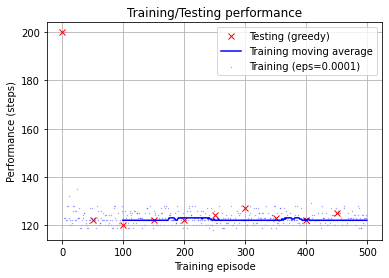

In [ ]:
#%% Monte Carlo implementation - training

class monte_carlo_update():
    """
    Function that provides the Monte Carlo update at the end of the episode
    """
    def __init__(self):
        """
        Initialize the Returns dict to store the return history across episodes
        """
        self.Returns = defaultdict(lambda : defaultdict(list))

    def __call__(self, episode, Q, alpha, gamma, *args, **kwargs):
        """
        Page 101, epsilon soft MC
        """
        # MC only updates after the entire episode is done
        if not episode[-1][DONE]:
            return
        else:
            G = 0
            sa_pairs = tuple([
                        (St, At) for St, At, Rt_1, St_1, At_1, done in episode])
            for t in reversed(range(len(episode))):
                St, At, Rt_1, St_1, At_1, done = episode[t]
                G = gamma * G + Rt_1
                if not (St, At) in sa_pairs[:t]:
                    self.Returns[St][At].append(G)
                    Q[St, At] = np.mean(self.Returns[St][At])

result = train(step_update_fun=monte_carlo_update(), gamma=0.999, eps = 0.0001, 
                                            n_training_episodes=500)
globals().update(result)

Testing episode ended in 124 steps at (array([0.47140206, 0.03942139]), 1, -1.0, array([0.51043357, 0.03903151]), 1, True)
Testing episode ended in 124 steps at (array([0.49701591, 0.03948877]), 1, -1.0, array([0.53630552, 0.03928961]), 1, True)
Testing episode ended in 122 steps at (array([0.49562182, 0.03069777]), 1, -1.0, array([0.52611002, 0.03048819]), 1, True)
Testing episode ended in 120 steps at (array([0.48086516, 0.04620308]), 1, -1.0, array([0.52674862, 0.04588346]), 1, True)
Testing episode ended in 124 steps at (array([0.46452505, 0.0396594 ]), 1, -1.0, array([0.50374371, 0.03921866]), 1, True)
Testing episode ended in 123 steps at (array([0.48987606, 0.0362015 ]), 1, -1.0, array([0.52582507, 0.03594901]), 1, True)
Testing episode ended in 124 steps at (array([0.47136147, 0.03953727]), 1, -1.0, array([0.51050856, 0.03914709]), 1, True)
Testing episode ended in 126 steps at (array([0.48018789, 0.0425236 ]), 1, -1.0, array([0.52238682, 0.04219893]), 1, True)
Testing episode 

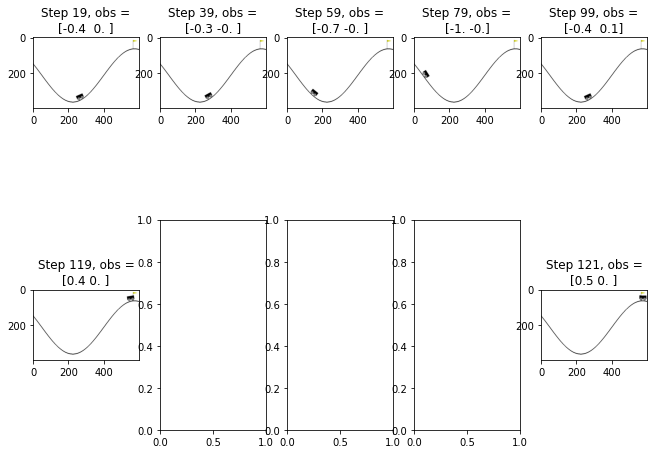

In [ ]:
#%% Monte Carlo testing

for i in range(10):
    episode = list(run_env(lambda o: np.argmax(Q[obs2state(o)]), plot=False))
    print(f"Testing episode ended in {len(episode)} steps at {episode[-1]}")

episode = list(run_env(lambda o: np.argmax(Q[obs2state(o)]), plot='display' in globals()))
print(f"Testing episode ended in {len(episode)} steps at {episode[-1]}")


Task 1: TD(0)
-------------

> Develop a TD(0) controller using:
> 
> *   on-policy SARSA
> *   on-policy expected SARSA
> *   off-policy expected SARSA with a greedy control policy.
> 
> Compare the performance of your controllers.
> 
> This will be graded.


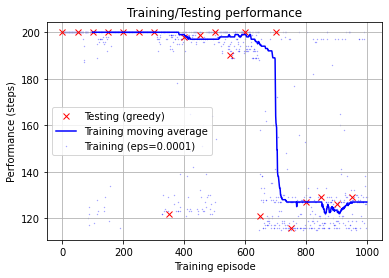

Testing episode ended in 127 steps at (array([0.48054219, 0.02733671]), 2, -1.0, array([0.50855687, 0.02801468]), 2, True)
Testing episode ended in 118 steps at (array([0.46729095, 0.03417527]), 2, -1.0, array([0.50204591, 0.03475496]), 2, True)
Testing episode ended in 127 steps at (array([0.48577421, 0.03574108]), 2, -1.0, array([0.52223222, 0.03645801]), 2, True)
Testing episode ended in 142 steps at (array([0.49605358, 0.01168358]), 2, -1.0, array([0.5085308 , 0.01247722]), 2, True)
Testing episode ended in 127 steps at (array([0.47995559, 0.02703911]), 2, -1.0, array([0.50766832, 0.02771272]), 2, True)
Testing episode ended in 196 steps at (array([0.46729095, 0.03417527]), 2, -1.0, array([0.50204591, 0.03475496]), 2, True)
Testing episode ended in 116 steps at (array([0.46729095, 0.03417527]), 2, -1.0, array([0.50204591, 0.03475496]), 2, True)
Testing episode ended in 116 steps at (array([0.46729095, 0.03417527]), 2, -1.0, array([0.50204591, 0.03475496]), 2, True)
Testing episode 

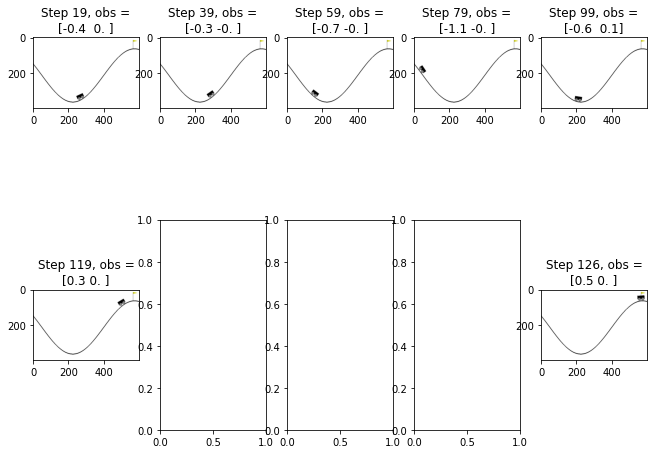

In [ ]:
#%% On-policy TD(0) SARSA Training and Testing

# Training

def sarsa_update_fun(episode, Q, alpha, gamma, *args, **kwargs):
    """
    Page 130 SARSA
    """
    s, a, r, s_, a_, done = episode[-1]
    Q[s, a] = Q[s, a] + alpha * (r + gamma * Q[s_, a_] * (1-done) - Q[s, a])

result = train(step_update_fun=sarsa_update_fun, 
               gamma=0.999, eps = 0.0001, alpha=0.20, n_training_episodes=1000)
globals().update(result)

# Testing

for i in range(10):
    episode = list(run_env(lambda o: np.argmax(Q[obs2state(o)]), plot=False))
    print(f"Testing episode ended in {len(episode)} steps at {episode[-1]}")

episode = list(run_env(lambda o: np.argmax(Q[obs2state(o)]), plot='display' in globals()))
print(f"Testing episode ended in {len(episode)} steps at {episode[-1]}")

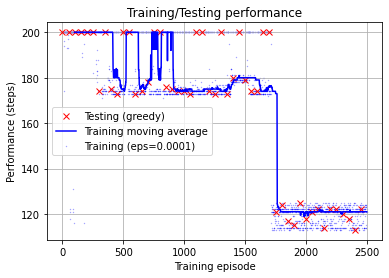

Testing episode ended in 124 steps at (array([0.4908947 , 0.04696426]), 2, -1.0, array([0.53861407, 0.04771937]), 2, True)
Testing episode ended in 118 steps at (array([0.48690072, 0.04923175]), 2, -1.0, array([0.5368578 , 0.04995707]), 2, True)
Testing episode ended in 115 steps at (array([0.48690072, 0.04923175]), 2, -1.0, array([0.5368578 , 0.04995707]), 2, True)
Testing episode ended in 122 steps at (array([0.48690072, 0.04923175]), 2, -1.0, array([0.5368578 , 0.04995707]), 2, True)
Testing episode ended in 121 steps at (array([0.46555968, 0.03435133]), 2, -1.0, array([0.50047792, 0.03491824]), 2, True)
Testing episode ended in 115 steps at (array([0.48690072, 0.04923175]), 2, -1.0, array([0.5368578 , 0.04995707]), 2, True)
Testing episode ended in 116 steps at (array([0.48690072, 0.04923175]), 2, -1.0, array([0.5368578 , 0.04995707]), 2, True)
Testing episode ended in 121 steps at (array([0.48690072, 0.04923175]), 2, -1.0, array([0.5368578 , 0.04995707]), 2, True)
Testing episode 

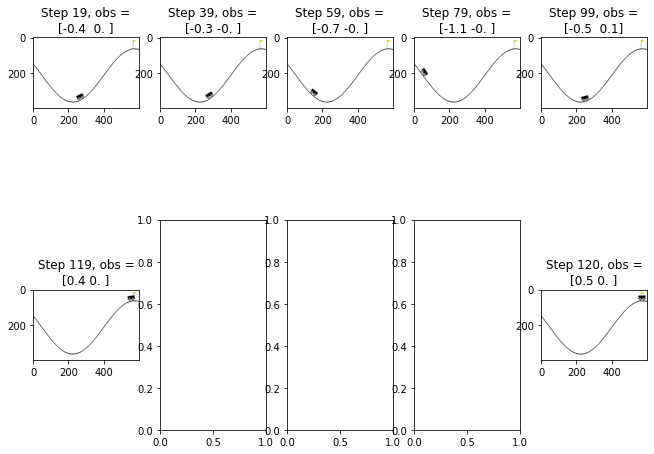

In [ ]:
#%% On-policy TD(0) expected SARSA - Training and Testing
# Here we use a eps-greedy on-policy for both behavior and the SARSA update

# Training

def eSARSA_eps_policy_update_fun(episode, Q, alpha, gamma, eps, *args, **kwargs):
    """
    Page 133
    """
    s, a, r, s_, a_, done = episode[-1]

    # Here p is the actual eps-soft probabilities
    p = np.full(Q.shape[1], fill_value=eps/Q.shape[1])
    p[np.argmax(Q[s_])] += 1.0-eps

    Q[s, a] = Q[s, a] + alpha * (r + gamma * (Q[s_] @ p) * (1-done) - Q[s, a])

# Use eps = 0.0 to make both behavior and actual policy completely greedy
result = train(step_update_fun=eSARSA_eps_policy_update_fun, 
               gamma=0.999, eps = 0.0001, alpha=0.20, n_training_episodes=2500)
globals().update(result)

# Testing

for i in range(10):
    episode = list(run_env(lambda o: np.argmax(Q[obs2state(o)]), plot=False))
    print(f"Testing episode ended in {len(episode)} steps at {episode[-1]}")

episode = list(run_env(lambda o: np.argmax(Q[obs2state(o)]), plot='display' in globals()))
print(f"Testing episode ended in {len(episode)} steps at {episode[-1]}")

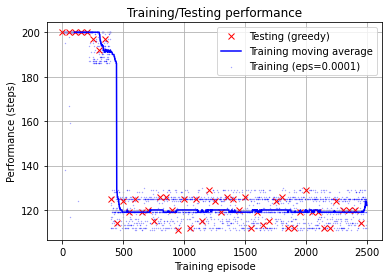

Testing episode ended in 125 steps at (array([0.48064508, 0.03454487]), 2, -1.0, array([0.51586868, 0.03522361]), 2, True)
Testing episode ended in 124 steps at (array([0.47229391, 0.03087987]), 2, -1.0, array([0.50379051, 0.03149661]), 2, True)
Testing episode ended in 119 steps at (array([0.49361306, 0.03926508]), 2, -1.0, array([0.53365355, 0.04004049]), 2, True)
Testing episode ended in 119 steps at (array([0.46547876, 0.0416082 ]), 2, -1.0, array([0.50765326, 0.0421745 ]), 2, True)
Testing episode ended in 112 steps at (array([0.46498407, 0.04286994]), 2, -1.0, array([0.50841665, 0.04343259]), 2, True)
Testing episode ended in 124 steps at (array([0.4742112 , 0.03115506]), 2, -1.0, array([0.50599721, 0.03178601]), 2, True)
Testing episode ended in 124 steps at (array([0.47649427, 0.03149159]), 2, -1.0, array([0.50863376, 0.03213948]), 2, True)
Testing episode ended in 126 steps at (array([0.49676082, 0.0269351 ]), 2, -1.0, array([0.52449486, 0.02773404]), 2, True)
Testing episode 

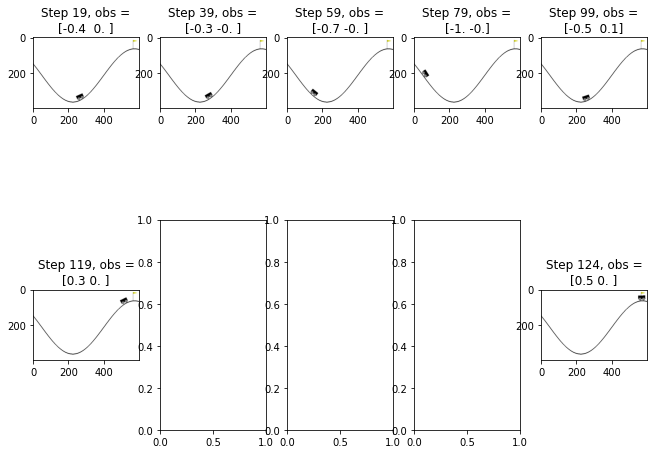

In [ ]:
#%% Off-policy TD(0) expected SARSA with a greedy control policy 
# suppose pi is the greedy policy while
# behavior is more exploratory; 
# then Expected Sarsa is exactly Q-learning - page 134

# Training and Testing

# Training

def eSARSA_update_fun(episode, Q, alpha, gamma, *args, **kwargs):
    """
    Page 133
    """
    s, a, r, s_, a_, done = episode[-1]

    # Here p is greedy - one for the greedy action, zero otherwise
    p = np.zeros(Q.shape[1]); p[np.argmax(Q[s_])] = 1.0

    Q[s, a] = Q[s, a] + alpha * (r + gamma * (Q[s_] @ p) * (1-done) - Q[s, a])

result = train(step_update_fun=eSARSA_update_fun, 
               gamma=0.999, eps = 0.0001, alpha=0.20, n_training_episodes=2500)
globals().update(result)

# Testing

for i in range(10):
    episode = list(run_env(lambda o: np.argmax(Q[obs2state(o)]), plot=False))
    print(f"Testing episode ended in {len(episode)} steps at {episode[-1]}")

episode = list(run_env(lambda o: np.argmax(Q[obs2state(o)]), plot='display' in globals()))
print(f"Testing episode ended in {len(episode)} steps at {episode[-1]}")

### Discussion 

All three controllers investigated in this section were able to achieve the goal within 200 steps after sufficient training. However, under the same training hyper-parameters ($\gamma$, $\alpha$, $\epsilon$), TD(0) on-policy SARSA typically trained much faster, converging in hundreds of episodes, compared to TD(0) on-policy expected SARSA and off-policy expected SARSA. Note that with sufficiently small $\epsilon$ the on-policy expected SARSA is very similar to off-policy expected SARSA with a greedy control policy; as a result the training efficiency between these two methods were indeed similar, both typically requiring more than one thousand episodes (with off-policy appearing to be slightly more efficient at times.) However, with the same $\gamma$, $\epsilon$, all TD(0) methods trained slower than on-policy Monte Carlo at the very beginning of this assignment.


Exercise 2: TD(n)
-----------------

> A useful ungraded exercise. Develop code for TD(n) predication, n-step SARSA (on-policy) control and off-policy Tree Backup control.
> 
> Test it out.

In [ ]:
#%% TD(n) n-step SARSA on-policy control implementation
# Page 147

class nSARSA:
    def __init__(self, n):
        """
        Parameters
        -----------------
        n : int
            n-step for SARSA
        """
        self.n = n

    def __call__(self, episode, Q, alpha, gamma, *args, **kwargs):
        # Convert to textbook convention (corresponding to page 147)
        episode = np.array(episode)
        Si, Ai, Ri, S_i, A_i, DONE = 0, 1, 2, 3, 4, 5
        S = np.concatenate((episode[:, Si], (episode[-1][S_i], ))).astype(np.int)
        A = np.concatenate((episode[:, Ai], (episode[-1][A_i], ))).astype(np.int)
        R = np.concatenate(( (0,) , episode[:, Ri] ))
        assert len(S) == len(A) == len(R)
        n = self.n
        # Calculate what is the current time step t
        t = len(episode) - 1
        ##
        
        ### n step SARSA update ###
        # if St+1 is terminal
        if episode[-1][DONE]:
            T = t + 1
        else:
            T = np.inf

        # tau is the time whose estimate is being updated
        tau = t - n + 1
        if tau >= 0:
            G = (gamma**np.arange(len(R[tau:tau+n])) * 
                                            R[tau:tau+n]).sum()
            if tau + n < T:
                G = G + gamma**n * Q[S[tau+n], A[tau+n]]
            Q[S[tau], A[tau]] = Q[S[tau], A[tau]] + alpha * (
                                                G - Q[S[tau], A[tau]])
        ###########################

# Testing is done below

# Tree back up is implemented at the end



Task 2: TD(2), TD(3), TD(4)
---------------------------

> Code controllers for TD(2), TD(3), and TD(4) using n-SARSA. Assess performance and compare against TD(0) and each other.
> 
> You may choose to use your work from Ex 2 for this (if you did Ex 2); otherwise you can code specific solvers for TD(2/3/4).


In [ ]:
#%% TD(n) SARSA

def train_tdn_sarsa(n):
    result = train(step_update_fun=nSARSA(n=n), 
                gamma=0.999, eps = 0.0001, alpha=0.20, n_training_episodes=1000)
    globals().update(result)

    # Testing
    print(f"TD({n}) SARSA results:")
    for i in range(10):
        episode = list(run_env(lambda o: np.argmax(Q[obs2state(o)]), plot=False))
        print(f"Testing episode ended in {len(episode)} steps at {episode[-1]}")

    episode = list(run_env(lambda o: np.argmax(Q[obs2state(o)]), plot='display' in globals()))
    print(f"Testing episode ended in {len(episode)} steps at {episode[-1]}")


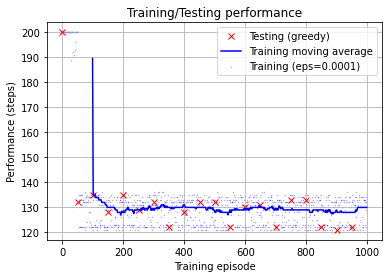

TD(0) SARSA results:
Testing episode ended in 132 steps at (array([0.48690072, 0.04923175]), 2, -1.0, array([0.5368578 , 0.04995707]), 2, True)
Testing episode ended in 122 steps at (array([0.46629504, 0.04237015]), 2, -1.0, array([0.50923752, 0.04294249]), 2, True)
Testing episode ended in 133 steps at (array([0.49245152, 0.0471119 ]), 2, -1.0, array([0.54033016, 0.04787863]), 2, True)
Testing episode ended in 128 steps at (array([0.47895409, 0.0432401 ]), 2, -1.0, array([0.52286036, 0.04390627]), 2, True)
Testing episode ended in 121 steps at (array([0.47435051, 0.03548223]), 2, -1.0, array([0.51046473, 0.03611421]), 2, True)
Testing episode ended in 134 steps at (array([0.49516788, 0.04795551]), 2, -1.0, array([0.54391041, 0.04874254]), 2, True)
Testing episode ended in 126 steps at (array([0.46899252, 0.0426721 ]), 2, -1.0, array([0.5122569 , 0.04326438]), 2, True)
Testing episode ended in 121 steps at (array([0.47571389, 0.03566485]), 2, -1.0, array([0.51202084, 0.03630695]), 2, T

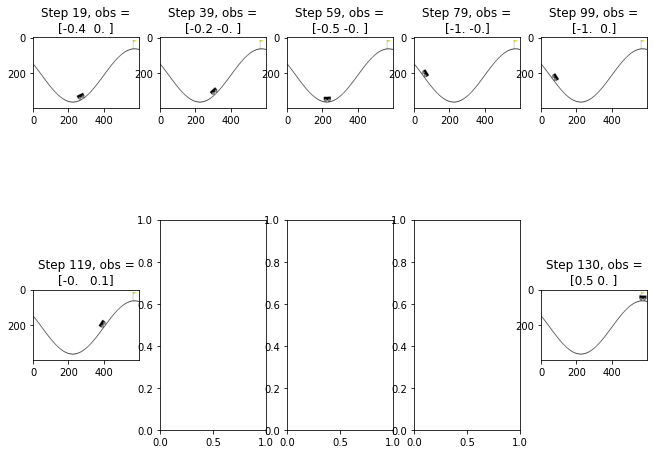

In [ ]:
train_tdn_sarsa(n=0)

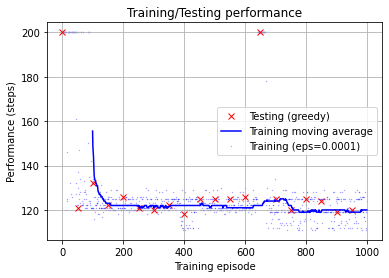

TD(2) SARSA results:
Testing episode ended in 125 steps at (array([0.47624454, 0.03353926]), 2, -1.0, array([0.51042984, 0.0341853 ]), 2, True)
Testing episode ended in 125 steps at (array([0.48413339, 0.0291085 ]), 2, -1.0, array([0.51394659, 0.0298132 ]), 2, True)
Testing episode ended in 126 steps at (array([0.48448406, 0.02574137]), 2, -1.0, array([0.51093275, 0.02644869]), 2, True)
Testing episode ended in 125 steps at (array([0.48142304, 0.02753615]), 2, -1.0, array([0.50964371, 0.02822067]), 2, True)
Testing episode ended in 120 steps at (array([0.49082167, 0.04029971]), 2, -1.0, array([0.53187595, 0.04105427]), 2, True)
Testing episode ended in 126 steps at (array([0.4769588 , 0.02502292]), 2, -1.0, array([0.50263307, 0.02567427]), 2, True)
Testing episode ended in 119 steps at (array([0.45996586, 0.04009802]), 2, -1.0, array([0.50058953, 0.04062366]), 2, True)
Testing episode ended in 113 steps at (array([0.46498407, 0.04286994]), 2, -1.0, array([0.50841665, 0.04343259]), 2, T

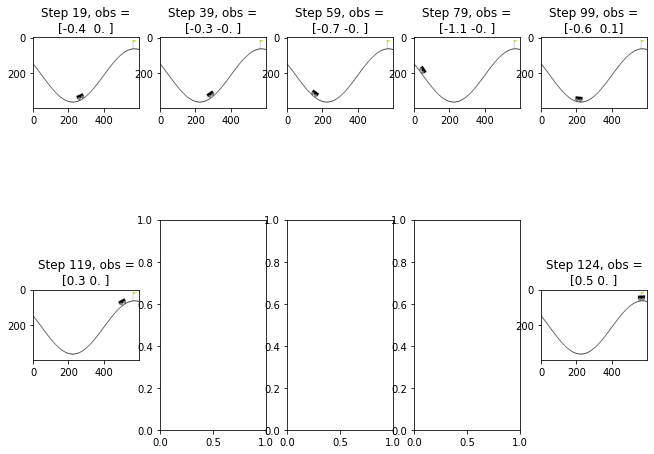

In [ ]:
train_tdn_sarsa(n=2)

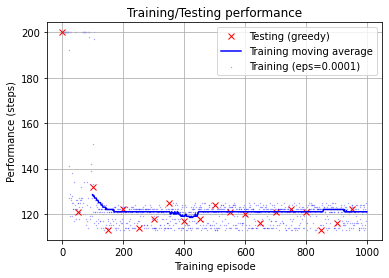

TD(3) SARSA results:
Testing episode ended in 119 steps at (array([0.48690072, 0.04923175]), 2, -1.0, array([0.5368578 , 0.04995707]), 2, True)
Testing episode ended in 122 steps at (array([0.48690072, 0.04923175]), 2, -1.0, array([0.5368578 , 0.04995707]), 2, True)
Testing episode ended in 114 steps at (array([0.48690072, 0.04923175]), 2, -1.0, array([0.5368578 , 0.04995707]), 2, True)
Testing episode ended in 121 steps at (array([0.47257233, 0.0382119 ]), 2, -1.0, array([0.51140303, 0.0388307 ]), 2, True)
Testing episode ended in 123 steps at (array([0.48398546, 0.04375183]), 2, -1.0, array([0.52844088, 0.04445542]), 2, True)
Testing episode ended in 115 steps at (array([0.48690072, 0.04923175]), 2, -1.0, array([0.5368578 , 0.04995707]), 2, True)
Testing episode ended in 123 steps at (array([0.48061374, 0.04522836]), 2, -1.0, array([0.5265206 , 0.04590686]), 2, True)
Testing episode ended in 113 steps at (array([0.48690072, 0.04923175]), 2, -1.0, array([0.5368578 , 0.04995707]), 2, T

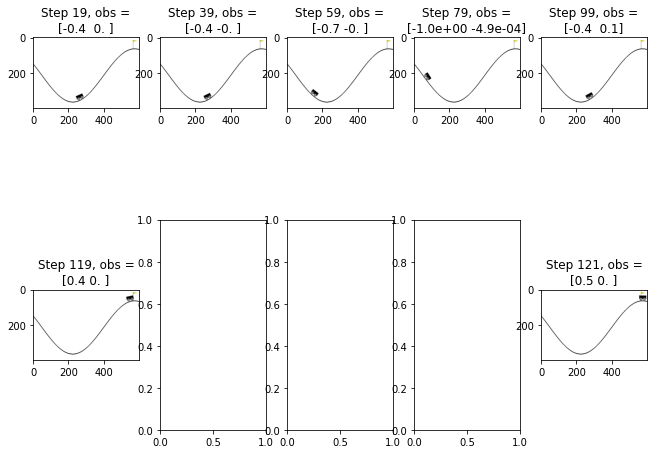

In [ ]:
train_tdn_sarsa(n=3)

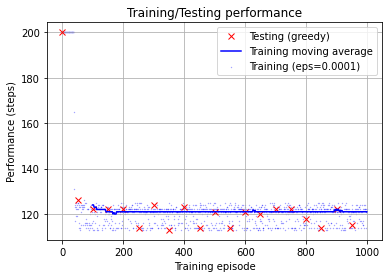

TD(4) SARSA results:
Testing episode ended in 123 steps at (array([0.47935605, 0.04553131]), 2, -1.0, array([0.52555651, 0.04620046]), 2, True)
Testing episode ended in 115 steps at (array([0.48690072, 0.04923175]), 2, -1.0, array([0.5368578 , 0.04995707]), 2, True)
Testing episode ended in 117 steps at (array([0.48690072, 0.04923175]), 2, -1.0, array([0.5368578 , 0.04995707]), 2, True)
Testing episode ended in 121 steps at (array([0.46574159, 0.03437401]), 2, -1.0, array([0.50068384, 0.03494226]), 2, True)
Testing episode ended in 122 steps at (array([0.47732289, 0.0323488 ]), 2, -1.0, array([0.51032573, 0.03300285]), 2, True)
Testing episode ended in 124 steps at (array([0.49016719, 0.04706004]), 2, -1.0, array([0.53797692, 0.04780973]), 2, True)
Testing episode ended in 122 steps at (array([0.4858128 , 0.04053049]), 2, -1.0, array([0.52706051, 0.0412477 ]), 2, True)
Testing episode ended in 117 steps at (array([0.48690072, 0.04923175]), 2, -1.0, array([0.5368578 , 0.04995707]), 2, T

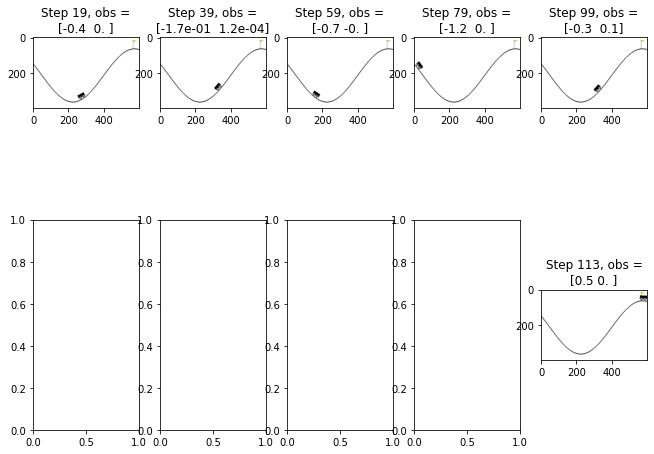

In [ ]:
train_tdn_sarsa(n=4)

### Discussion

Among TD(n) SARSA controllers, larger n usually achieved more efficient training. For example, while TD(0) and TD(2) typically required more than one hundred episodes to converge to solution, TD(3) and TD(4) typically required less than one hundred episodes. This is in agreement with the original observation that Monte Carlo (i.e. TD($\infty$)) almost always achieved very efficient training.


Bonus Task 3: Tree Backup
-------------------------

> This is optional; if you do this, your grade can exceed 100% and will offset other grades.
>
> Assess the performance of Tree Backup for TD(2), TD(3), and TD(4) versus the respective n-SARSA controller.


In [2]:
#%% Tree backup 
# Page 154
# Simplified for a greedy policy


class nTreeBackup:
    def __init__(self, n):
        """
        Parameters
        -----------------
        n : int
            n-step for Tree Backup
        """
        self.n = n

    def __call__(self, episode, Q, alpha, gamma, *args, **kwargs):
        # Convert to textbook convention (corresponding to page 147)
        episode = np.array(episode)
        Si, Ai, Ri, S_i, A_i, DONE = 0, 1, 2, 3, 4, 5
        S = np.concatenate((episode[:, Si], (episode[-1][S_i], ))).astype(np.int)
        A = np.concatenate((episode[:, Ai], (episode[-1][A_i], ))).astype(np.int)
        R = np.concatenate(( (0,) , episode[:, Ri] ))
        assert len(S) == len(A) == len(R)
        n = self.n
        # Calculate what is the current time step t
        t = len(episode) - 1
        ##
        
        ### n step Tree Backup update ###
        # if St+1 is terminal
        if episode[-1][DONE]:
            T = t + 1
        else:
            T = np.inf

        # tau is the time whose estimate is being updated
        tau = t - n + 1
        if tau >= 0:
            if t + 1 >= T:
                G = R[t]
            else:
                # Simplified for greedy policy
                G = R[t+1] + gamma * np.max(Q[S[t+1]])
            
            for k in range(min(t, T-1), tau+1-1, -1): # Adapted syntax for Python
                # Adapted for greedy policy
                if np.argmax(Q[S[k]]) != A[k]:
                    G = R[k] + gamma * np.max(Q[S[k]])
                else:
                    G = R[k] + gamma * G

            Q[S[tau], A[tau]] = Q[S[tau], A[tau]] + alpha * (
                                                G - Q[S[tau], A[tau]])
        ###########################

def train_tdn_tree_backup(n):
    result = train(step_update_fun=nTreeBackup(n=n), 
                gamma=0.999, eps = 0.0001, alpha=0.20, n_training_episodes=1000)
    globals().update(result)

    # Testing
    print(f"TD({n}) SARSA results:")
    for i in range(10):
        episode = list(run_env(lambda o: np.argmax(Q[obs2state(o)]), plot=False))
        print(f"Testing episode ended in {len(episode)} steps at {episode[-1]}")

    episode = list(run_env(lambda o: np.argmax(Q[obs2state(o)]), plot='display' in globals()))
    print(f"Testing episode ended in {len(episode)} steps at {episode[-1]}")


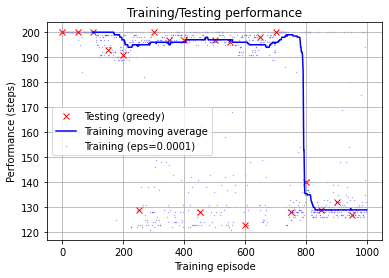

TD(2) SARSA results:
Testing episode ended in 126 steps at (array([0.49766917, 0.02708627]), 2, -1.0, array([0.52556116, 0.02789199]), 2, True)
Testing episode ended in 128 steps at (array([0.48333525, 0.02534325]), 2, -1.0, array([0.50937725, 0.026042  ]), 2, True)
Testing episode ended in 127 steps at (array([0.49481833, 0.02667502]), 2, -1.0, array([0.52227776, 0.02745943]), 2, True)
Testing episode ended in 129 steps at (array([0.49013089, 0.02811261]), 2, -1.0, array([0.51899292, 0.02886203]), 2, True)
Testing episode ended in 127 steps at (array([0.47838272, 0.02505099]), 2, -1.0, array([0.50409563, 0.02571291]), 2, True)
Testing episode ended in 129 steps at (array([0.49444428, 0.02851192]), 2, -1.0, array([0.52373781, 0.02929354]), 2, True)
Testing episode ended in 127 steps at (array([0.47923682, 0.0274317 ]), 2, -1.0, array([0.50733679, 0.02809997]), 2, True)
Testing episode ended in 129 steps at (array([0.48758355, 0.03079492]), 2, -1.0, array([0.51910887, 0.03152533]), 2, T

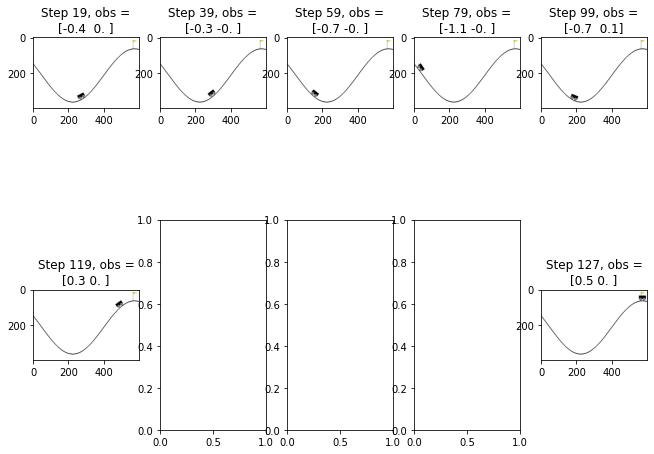

In [12]:
# Tree backup TD(n) training and testing

train_tdn_tree_backup(n=2)

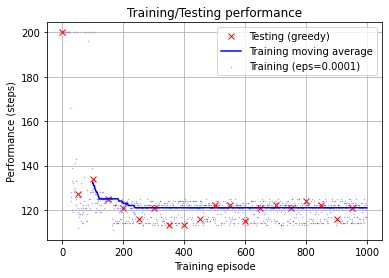

TD(3) SARSA results:
Testing episode ended in 122 steps at (array([0.48626541, 0.04065668]), 2, -1.0, array([0.52764267, 0.04137727]), 2, True)
Testing episode ended in 122 steps at (array([0.46425936, 0.04098872]), 2, -1.0, array([0.50580538, 0.04154602]), 2, True)
Testing episode ended in 122 steps at (array([0.47558524, 0.03216479]), 2, -1.0, array([0.50839118, 0.03280594]), 2, True)
Testing episode ended in 121 steps at (array([0.47770726, 0.03593593]), 2, -1.0, array([0.51430009, 0.03659283]), 2, True)
Testing episode ended in 114 steps at (array([0.48690072, 0.04923175]), 2, -1.0, array([0.5368578 , 0.04995707]), 2, True)
Testing episode ended in 122 steps at (array([0.48360892, 0.03302361]), 2, -1.0, array([0.51733333, 0.03372441]), 2, True)
Testing episode ended in 124 steps at (array([0.49102513, 0.04694669]), 2, -1.0, array([0.5387279 , 0.04770278]), 2, True)
Testing episode ended in 121 steps at (array([0.48243283, 0.03660038]), 2, -1.0, array([0.51972525, 0.03729242]), 2, T

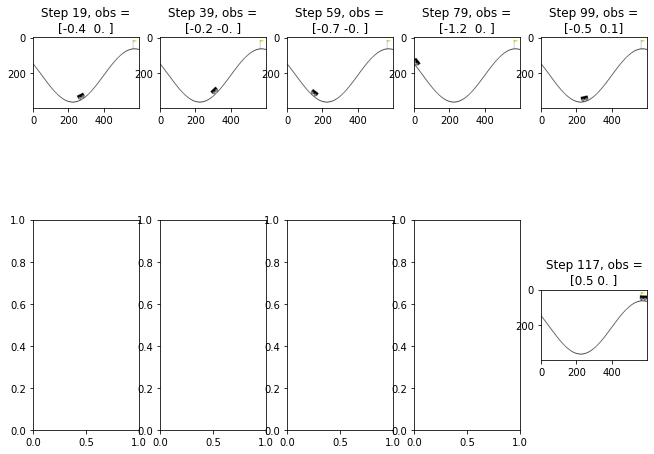

In [13]:
train_tdn_tree_backup(n=3)

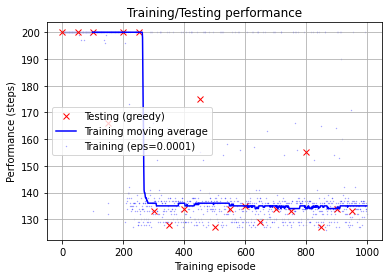

TD(4) SARSA results:
Testing episode ended in 133 steps at (array([0.4842826 , 0.02609506]), 2, -1.0, array([0.51108347, 0.02680087]), 2, True)
Testing episode ended in 136 steps at (array([0.47502244, 0.03438161]), 2, -1.0, array([0.51004101, 0.03501857]), 2, True)
Testing episode ended in 136 steps at (array([0.49305395, 0.02867267]), 2, -1.0, array([0.52249786, 0.0294439 ]), 2, True)
Testing episode ended in 129 steps at (array([0.48884389, 0.01942254]), 2, -1.0, array([0.50900623, 0.02016235]), 2, True)
Testing episode ended in 130 steps at (array([0.48566589, 0.01790327]), 2, -1.0, array([0.50428528, 0.01861939]), 2, True)
Testing episode ended in 137 steps at (array([0.47678417, 0.03558008]), 2, -1.0, array([0.5130143 , 0.03623012]), 2, True)
Testing episode ended in 129 steps at (array([0.49452032, 0.02137197]), 2, -1.0, array([0.51667447, 0.02215416]), 2, True)
Testing episode ended in 136 steps at (array([0.4984093 , 0.02772929]), 2, -1.0, array([0.52694985, 0.02854055]), 2, T

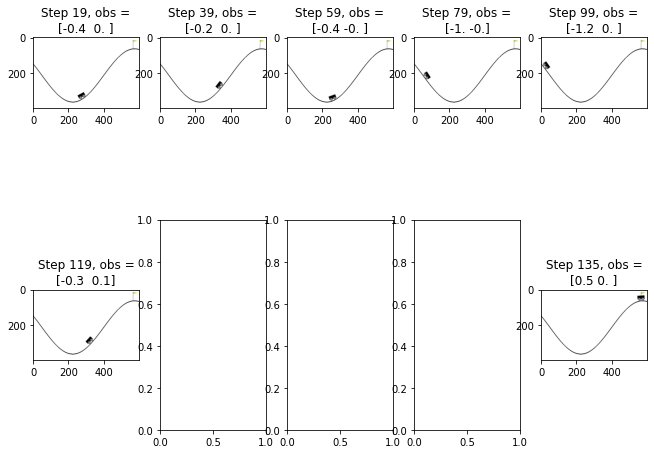

In [11]:
train_tdn_tree_backup(n=4)

### Discussion

The tree backup algorithms also converge to good solutions, but appear to be harder to train requiring more episodes to converge (all typically take more than one hundred episodes) than the TD(n) SARSA equivalents, when using the same hyper-parameters. 


Submission:
-----------

> Submit a pdf containing your code --- in order --- and traces/logs indicating the controlling of the environment (instrument your code). Clearly include performance results (annotated with any parameters you chose). When asked to compare, show tables, and include discussion where needed to ensure your results are presented clearly. The TA can only grade what they see clearly presented; it is your responsibility to ensure this is the case. Follow the structure of the assignment spec.
> 
> 1615953599 03/16/2021 11:59pm